### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Loading dataset and sanity checking

In [2]:
df = pd.read_excel('netflix.xlsx')
df.head()

,Subscriber ID,Show Name,Episodes Watched,Episode Length (m)
0,1,Stranger Things,49.408890,66
1,1,Dark,43.643054,65
2,1,Queen Of Tears,11.240759,75
3,1,You,47.004729,55
4,1,Dexter,44.545914,55


In [3]:
df.isnull().sum() # Checking nulls

Subscriber ID         0
Show Name             0
Episodes Watched      0
Episode Length (m)    0
dtype: int64

In [4]:
df.duplicated().sum() # Checking duplicates

0

### Standardise column names & fix types

In [5]:
df = df.rename(columns ={
    "Subscriber ID" : "subscriber_id",
    "Show Name": "show_name",
    "Episodes Watched": "episodes_watched",
    "Episode Length (m)": "episode_length_m",
})

df.head()

,subscriber_id,show_name,episodes_watched,episode_length_m
0,1,Stranger Things,49.408890,66
1,1,Dark,43.643054,65
2,1,Queen Of Tears,11.240759,75
3,1,You,47.004729,55
4,1,Dexter,44.545914,55


### Adding a new column named total minutes watched 

In [6]:
df["total_minutes_watched"] = df["episodes_watched"] * df["episode_length_m"]
df.head()

,subscriber_id,show_name,episodes_watched,episode_length_m,total_minutes_watched
0,1,Stranger Things,49.408890,66,3260.986731
1,1,Dark,43.643054,65,2836.798498
2,1,Queen Of Tears,11.240759,75,843.056896
3,1,You,47.004729,55,2585.260111
4,1,Dexter,44.545914,55,2450.025295


### User–Item matrix

In [7]:
user_item = df.pivot_table(
    index = "subscriber_id",
    columns = "show_name",
    values="total_minutes_watched"
)
user_item.head()

show_name,Big Bang Theory,Dahmer,Dark,Dexter,It's Okay To Not Be Okay,Queen Of Tears,Stranger Things,Umbrella Academy,You
subscriber_id,,,,,,,,,
1,3703.445834,2509.752701,2836.798498,2450.025295,115.039154,843.056896,3260.986731,3121.123912,2585.260111
2,3031.447359,1615.965690,2608.982488,1492.754844,1806.341470,1827.583998,2593.788225,2380.032088,1445.646460
3,2270.139589,1300.928979,2175.690088,1774.098904,1530.634705,1438.599414,2882.434104,1893.273819,1323.562076
4,2630.000677,2642.493691,2865.152354,2361.183717,900.705625,918.759948,2804.159203,2743.569033,2412.546482
5,3274.282773,3433.788401,2074.901910,2246.941606,1751.980120,1959.810722,1419.808517,1913.160473,2611.333877


### Item–item correlation matrix

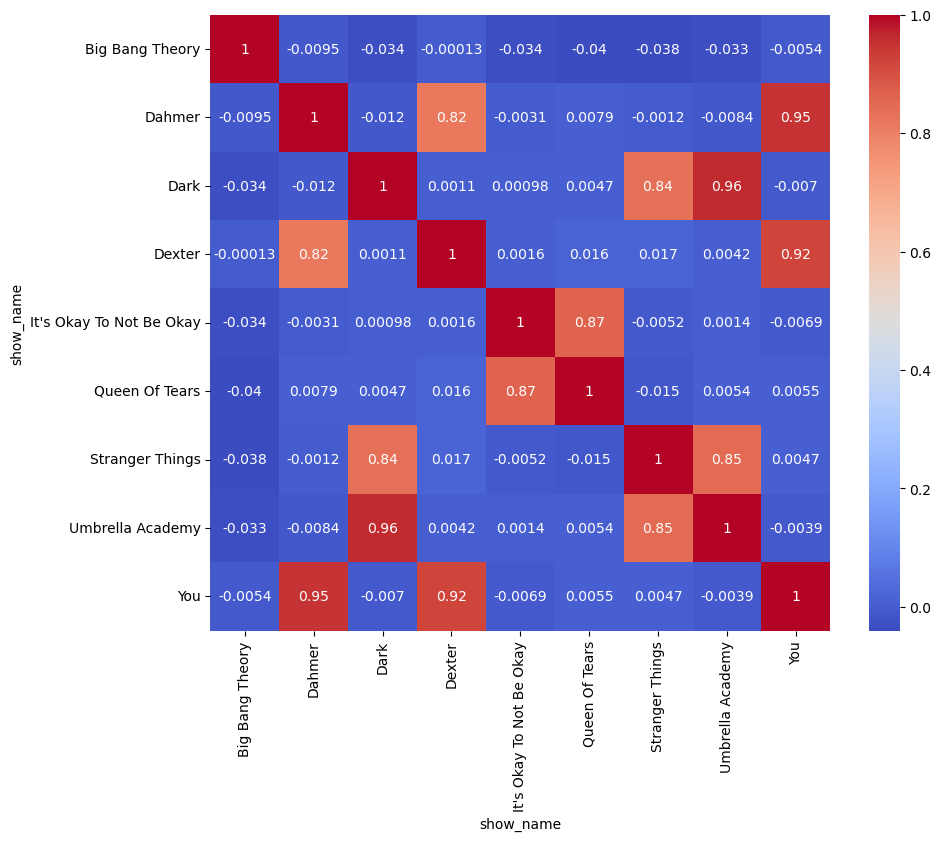

In [8]:
corr_mat = user_item.corr(min_periods=1)

plt.figure(figsize = (10, 8))
sns.heatmap(corr_mat, annot =True, cmap = "coolwarm")
plt.show()

### Recommendation using item–item collaborative filtering

In [9]:
def recommend_similar(show, corr_matrix, k=5, min_corr=0.2): 
    
    # k is the number of recommendation we want to return
    # We sent min correlation must be over 0.3 to recommend a series
    
    if show not in corr_matrix.columns: # if the show is not available
        raise ValueError(f"{show} not found in correlation matrix")
    
    # Drop itself
    sim_score = corr_matrix[show].drop(labels=[show])
    
    # Filter out low correlations
    sim_score = sim_score[sim_score >= min_corr].sort_values(ascending=False)
    
    return sim_score.head(k)


# Example: shows similar to 'Dexter'
recommend_similar("Dexter", corr_mat, k=5)


show_name
You       0.921600
Dahmer    0.821099
Name: Dexter, dtype: float64

No recommendations for Big Bang Theory (not enough correlations)



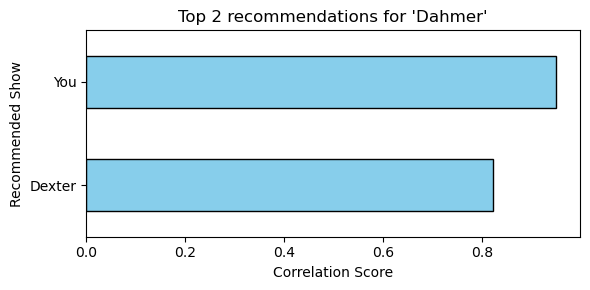

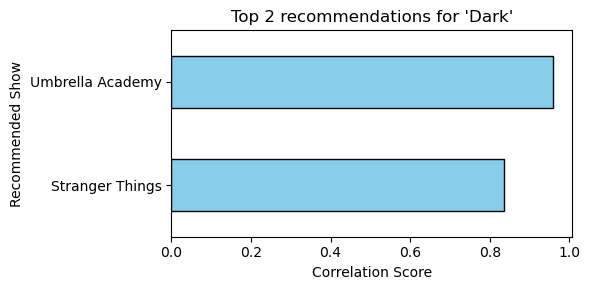

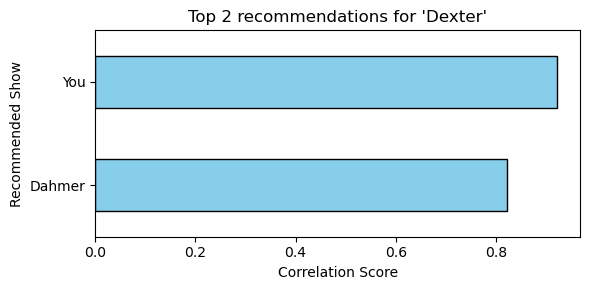

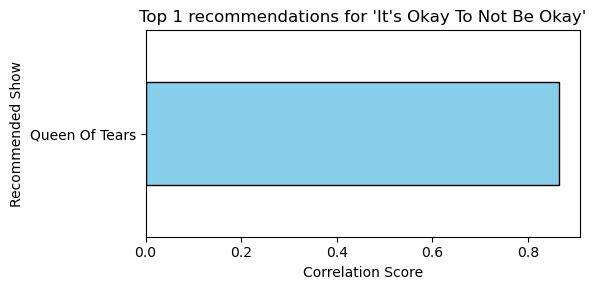

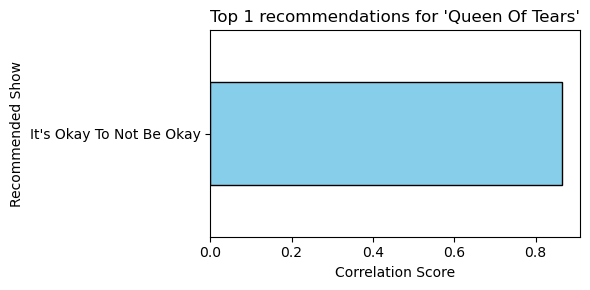

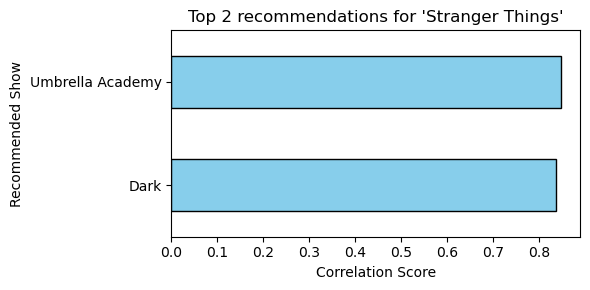

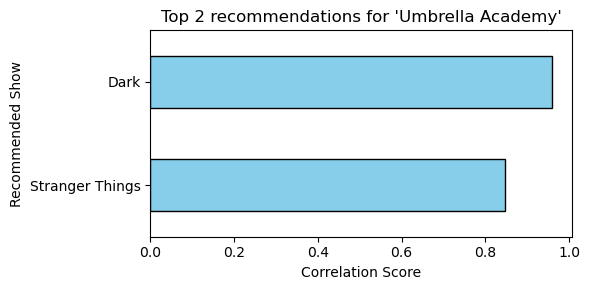

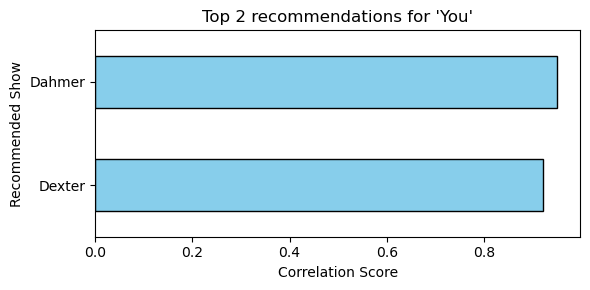

In [19]:
def plot_recommendations(corr_matrix, k=5, min_corr=0.2):
    """
    For each show in corr_matrix, plot a horizontal bar chart
    of its top-k similar recommended shows.
    """
    shows = corr_matrix.columns
    
    for show in shows:
        try:
            recs = recommend_similar(show, corr_matrix, k=k, min_corr=min_corr)
            
            if recs.empty:
                print(f"No recommendations for {show} (not enough correlations)\n")
                continue
            
            # Plot horizontal bar chart
            plt.figure(figsize=(6, 3))
            recs.sort_values().plot(kind="barh", color="skyblue", edgecolor="black")
            plt.title(f"Top {len(recs)} recommendations for '{show}'")
            plt.xlabel("Correlation Score")
            plt.ylabel("Recommended Show")
            plt.tight_layout()
            plt.show()
        
        except Exception as e:
            print(f"Skipping {show}: {e}")


plot_recommendations(corr_mat, k=5, min_corr=0.2)
